In [60]:
import os
import torch
import torchvision
import imageio
import torch.nn as nn
import matplotlib.pyplot as plt


from torchvision import transforms
from torch.utils.data import DataLoader
from IPython.display import Image
from torchvision.utils import save_image

In [25]:
# Use GPU to train the model, otherwise use CPU
# GPU will decrease the training time significantly

print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device

True


'cuda'

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST("./data", download=True, transform=transform)

In [27]:
print(f'[dataset shape: {dataset.data.shape} and type: {type(dataset.data)}]\n[target shape: {dataset.targets.shape} and type: {type(dataset.targets)}]')

[dataset shape: torch.Size([60000, 28, 28]) and type: <class 'torch.Tensor'>]
[target shape: torch.Size([60000]) and type: <class 'torch.Tensor'>]


In [28]:
# Looking at the data
x, y = dataset[0]
x.shape, type(y)

(torch.Size([1, 28, 28]), int)

Text(0.5, 1.0, 'Label: 5')

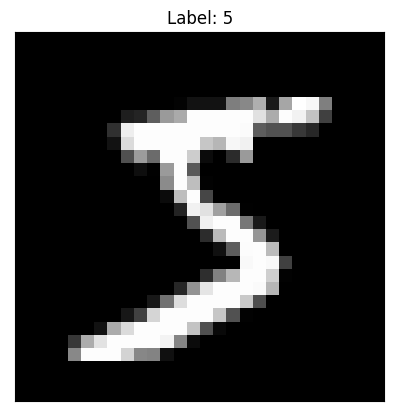

In [29]:
x.squeeze_()
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f'Label: {y}')

In [30]:
img, label = dataset[0]
print(f'Label: {label}')
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

Label: 5


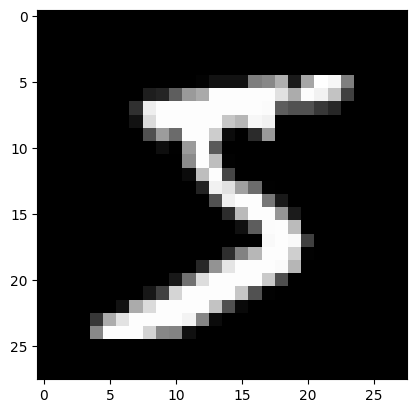

In [31]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print(f'Label: {label}')

In [34]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=True)

First batch:
torch.Size([100, 1, 28, 28])
tensor([1, 6, 8, 9, 9, 5, 8, 0, 4, 2, 7, 7, 7, 3, 5, 7, 8, 6, 6, 8, 8, 3, 1, 2,
        7, 2, 5, 3, 8, 1, 5, 8, 4, 0, 7, 5, 9, 4, 5, 8, 7, 8, 4, 8, 6, 2, 4, 3,
        1, 0, 1, 1, 5, 2, 6, 7, 0, 7, 3, 8, 3, 3, 2, 2, 1, 0, 0, 7, 5, 2, 9, 9,
        4, 9, 5, 3, 6, 8, 9, 4, 1, 1, 7, 9, 2, 8, 6, 5, 9, 0, 4, 7, 2, 4, 8, 7,
        0, 2, 2, 6])


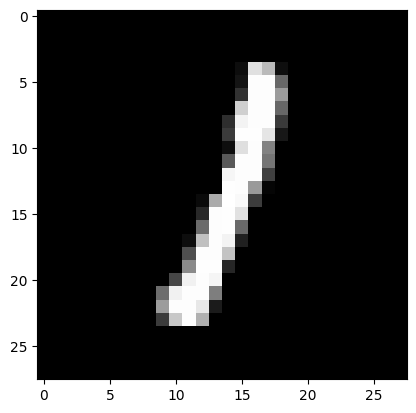

In [37]:
for img_batch, label_batch in dataloader:
    print('First batch:')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [38]:
img_size = 784 # (28*28)
hidden_size = 256

In [39]:
Discriminator = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)
Discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [40]:
latent_size = 64
Generator = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh()
)

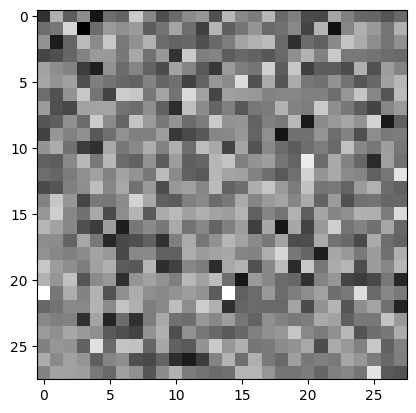

In [41]:
Y = Generator(torch.randn(2, latent_size))
gen_imgs = denorm(Y.reshape((-1, 28, 28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')

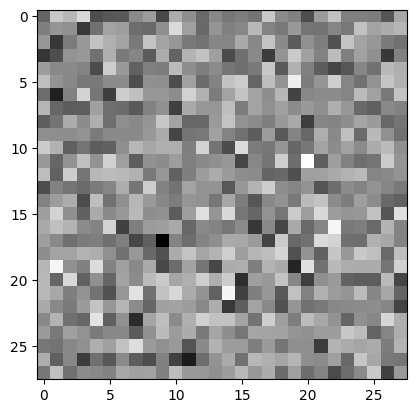

In [42]:
plt.imshow(gen_imgs[1], cmap='gray')

In [43]:
Generator.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [45]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(Generator.parameters(), lr=0.0002)

In [46]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [47]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    outputs = Discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator(z)
    outputs = Discriminator(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    d_loss = d_loss_real + d_loss_fake
    reset_grad
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score
    

In [48]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(Discriminator(fake_images), labels)
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [51]:
sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

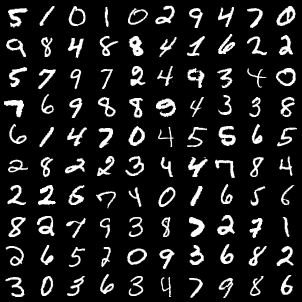

In [52]:
for images, _ in dataloader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


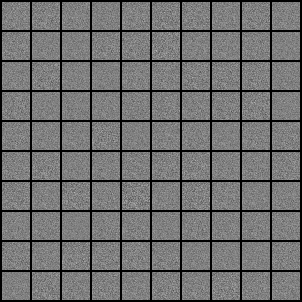

In [56]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = Generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Save before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [58]:
%%time
num_epochs = 300
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.reshape(batch_size, -1).to(device)
        
        # training the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                                                                                                                      real_score.mean().item(), fake_score.mean().item()))
    save_fake_images(epoch+1)
            

Epoch [0/300], Step [200/600], d_loss: 0.7772, g_loss: 0.7185, D(x): 0.98, D(G(z)): 0.53
Epoch [0/300], Step [400/600], d_loss: 0.7901, g_loss: 0.7226, D(x): 0.96, D(G(z)): 0.53
Epoch [0/300], Step [600/600], d_loss: 0.8096, g_loss: 0.7272, D(x): 0.97, D(G(z)): 0.54
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.9380, g_loss: 0.7146, D(x): 0.96, D(G(z)): 0.59
Epoch [1/300], Step [400/600], d_loss: 1.0172, g_loss: 0.6453, D(x): 0.86, D(G(z)): 0.58
Epoch [1/300], Step [600/600], d_loss: 1.3620, g_loss: 0.4665, D(x): 0.80, D(G(z)): 0.67
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.9015, g_loss: 0.6780, D(x): 0.94, D(G(z)): 0.57
Epoch [2/300], Step [400/600], d_loss: 1.1397, g_loss: 0.5293, D(x): 0.83, D(G(z)): 0.61
Epoch [2/300], Step [600/600], d_loss: 0.9125, g_loss: 0.5754, D(x): 0.90, D(G(z)): 0.55
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.9382, g_loss: 0.6671, D(x): 0.91, D(G(z)): 0.56
Epoch [3/300], Step [400/6

In [59]:
# save the model 
torch.save(Generator.state_dict(), './MNIST_Generator_Attempt3.pt')
torch.save(Discriminator.state_dict(), './MNIST_Discriminator_Attempt3.pt')

In [63]:
def load_images_from_dir(directory):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = imageio.imread(os.path.join(directory, filename))
            image_list.append(image)
    return image_list

images = load_images_from_dir(sample_dir)
imageio.mimsave('samples/out.gif', images, fps=20)

C:\Users\faree\AppData\Local\Temp\ipykernel_11128\4028916951.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(directory, filename))
